In [1]:
import time

import pandas as pd # used to load the data
import numpy as np # optimized numerical library

from sklearn import preprocessing, metrics, utils, decomposition, model_selection, linear_model, discriminant_analysis, svm, tree, ensemble # library providing several ML algorithms and related utility

from imblearn import over_sampling # provides several resampling techniques to cope with unbalanced datasets (https://github.com/scikit-learn-contrib/imbalanced-learn) compatible with sklearn

from collections import Counter

import matplotlib.pyplot as plt # used for plotting

# Start by defining three helper functions:
# - one to plot the sample distribution  acorss the class labels (to see how un-/balanced the dataset is)
# - one to compute and plot the confusion matrix
# - one to plot data in 2D with different colors per class label

def plot_pie(y, labels, title=""):
    target_stats = Counter(y)
    sizes = list(target_stats.values())
    explode = tuple([0.1] * len(target_stats))

    fig, ax = plt.subplots()
    ax.set_title(title + " (size: %d)" % len(y))
    ax.pie(sizes, explode=explode, labels=target_stats.keys(), shadow=True, autopct='%1.1f%%')
    ax.axis('equal')


def compute_and_plot_cm(ytest, ypred, labels, title=""):
    global nfigure
    # Compute confusion matrix
    cm = metrics.confusion_matrix(ytest, ypred)
    
    accuracy = metrics.accuracy_score(ytest, ypred, normalize=True)

    # Normalize the matrix
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    print(cm)

    # Plot the confusion matrix

    nfigure = nfigure + 1
    plt.figure(nfigure) # new numbered figure
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues) # plot the confusionmatrix using blue shaded colors
    plt.title("Confusion Matrix Normalized (%s) Accuracy: %.1f%%" % (title, accuracy*100)) # add title
    plt.colorbar() # plot the color bar as legend

    # Plot the x and y ticks using the class label names
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)


def plot_2d(xpred, ypred, labels, title=""):
    global nfigure
    # define the colors to use for each class label
    colors = ['red', 'blue', 'green', 'yellow', 'black']
    len_colors = len(colors)
    if len_colors < len(labels):
        print("WARNING: we have less colors than classes: some classes will reuse the same color")

    nfigure = nfigure + 1
    plt.figure(nfigure) # new numbered figure
    plt.title("Feature Space (%s)" % title) # add title


    # plot each class label with a separate color 
    for c in range(len(labels)):
        cur_class = (ypred == c) # get all points belonging to class c
        plt.plot(xpred[cur_class, 0], xpred[cur_class, 1], 'o', color=colors[c % len_colors]) # plot class c


nfigure = 0 #used to number the figures

C:\WinPython\python-3.7.0b3.amd64\lib\site-packages\sklearn\utils\__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


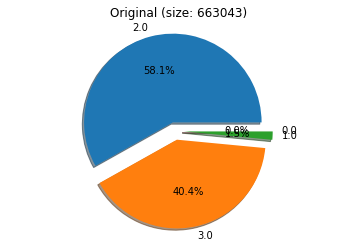

In [2]:
################ Load data ####################
# Get the dataset loaded and define class labels 
data = pd.read_csv('data/jobs.csv', header=0)
data_class_labels = ["evict", "fail", "finish", "kill"]

# All data columns except last are input features (X), last column is output label (y)
n_features = len(data.columns) - 1

X = data.iloc[:,0:n_features]
y = data.iloc[:,n_features]

y = y - 2 #First two labels not in dataset, shift by two

plot_pie(y, data_class_labels, "Original")

In [ ]:
################ Resample data #################

# Google data is very skewed, try to balance the dataset
sm = over_sampling.SMOTE(random_state=42, ratio="auto")
X, y = sm.fit_sample(X, y)

# Plot the balanced label distribution
plot_pie(y, data_class_labels, "Balanced")


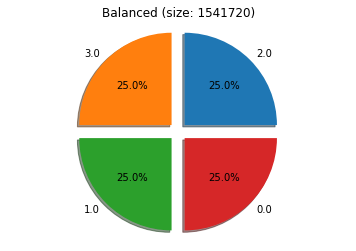

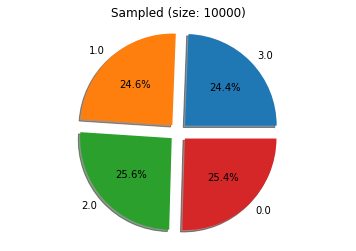

In [3]:

# Resample the data with simple random resampling (if too big)
# - replace decideds if sampling with or without replacement
# - n_samples decide the size of the ouput: if set to None ouput = input (i.e. no resampling)
X, y = utils.resample(X, y, replace=False, n_samples=10000)

# Plot the resampled label distribution

plot_pie(y, data_class_labels, "Sampled")

In [ ]:
################ Split data ####################
# Split data in training and testing
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33, random_state=42)

In [5]:
################ Scale data ####################
# Train a scaler to standardize the features (zero mean and unit variance)
scaler = preprocessing.StandardScaler().fit(X_train)

# ... and scale the features
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
################ PCA ####################
# Train a PCA with 2 dimensions
pca = decomposition.PCA(n_components=2).fit(X_train_scaled)

# ... and apply it to the features
X_train_scaled_pca = pca.transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)

Acuracy of LR : 64.5%
[[0.94028103 0.02693208 0.00234192 0.03044496]
 [0.09878049 0.42439024 0.28658537 0.1902439 ]
 [0.12677725 0.12559242 0.66469194 0.08293839]
 [0.06521739 0.17774936 0.22634271 0.53069054]]


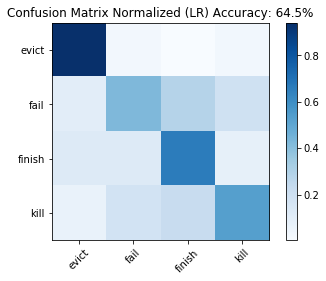

In [7]:
################ Logit ##################
# Train a Logit model on the original features
lr = linear_model.LogisticRegression().fit(X_train_scaled, y_train)

# Compute the predicted labels on test data
y_lr = lr.predict(X_test_scaled)
print("Acuracy of LR : %.1f%%" % (metrics.accuracy_score(y_test,y_lr)*100))

compute_and_plot_cm(y_test, y_lr, data_class_labels, title="LR")

Acuracy of LR + PCA: 39.8%
[[0.82786885 0.03278689 0.         0.13934426]
 [0.3304878  0.06219512 0.55731707 0.05      ]
 [0.2985782  0.03909953 0.6457346  0.01658768]
 [0.48081841 0.07672634 0.43094629 0.01150895]]


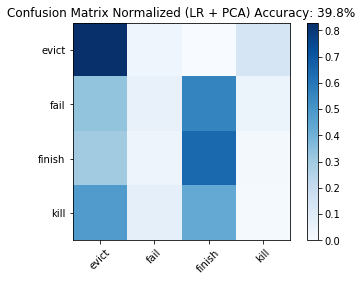

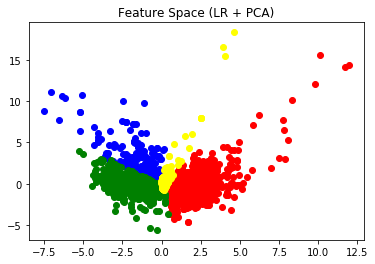

In [8]:
# Train a Logit model on pca extracted features
lr_pca = linear_model.LogisticRegression().fit(X_train_scaled_pca, y_train)

# Compute the predicted labels on test data
y_lr_pca = lr_pca.predict(X_test_scaled_pca)

print("Acuracy of LR + PCA: %.1f%%" % (metrics.accuracy_score(y_test,y_lr_pca)*100))

compute_and_plot_cm(y_test, y_lr_pca, data_class_labels, title="LR + PCA")

plot_2d(X_test_scaled_pca, y_lr_pca, data_class_labels, title="LR + PCA")

Acuracy of LDA : 62.6%
[[0.92154567 0.03629977 0.         0.04215457]
 [0.09268293 0.46341463 0.22195122 0.22195122]
 [0.11729858 0.12559242 0.62677725 0.13033175]
 [0.08695652 0.19053708 0.24936061 0.47314578]]


C:\WinPython\python-3.7.0b3.amd64\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


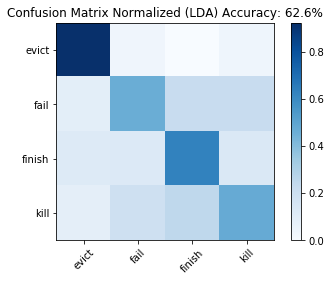

In [9]:
################ LDA ##################
# Train an LDA model on original features
lda = discriminant_analysis.LinearDiscriminantAnalysis().fit(X_train_scaled, y_train)

# Compute the predicted labels on test data
y_lda = lda.predict(X_test_scaled)

print("Acuracy of LDA : %.1f%%" % (metrics.accuracy_score(y_test,y_lda)*100))

compute_and_plot_cm(y_test, y_lda, data_class_labels, title="LDA")

Acuracy of LDA + PCA: 36.0%
[[0.69437939 0.03278689 0.         0.27283372]
 [0.2902439  0.05365854 0.55609756 0.1       ]
 [0.25118483 0.03791469 0.63625592 0.07464455]
 [0.47826087 0.07161125 0.43350384 0.01662404]]


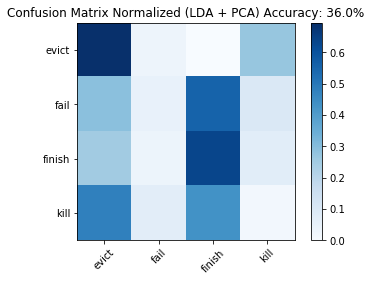

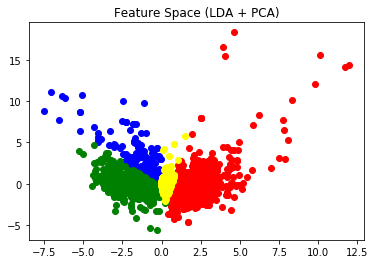

In [10]:
# Train an LDA model on pca extracted features
lda_pca = discriminant_analysis.LinearDiscriminantAnalysis().fit(X_train_scaled_pca, y_train)

# Compute the predicted labels on test data
y_lda_pca = lda_pca.predict(X_test_scaled_pca)

print("Acuracy of LDA + PCA: %.1f%%" % (metrics.accuracy_score(y_test,y_lda_pca)*100))

compute_and_plot_cm(y_test, y_lda_pca, data_class_labels, title="LDA + PCA")

plot_2d(X_test_scaled_pca, y_lda_pca, data_class_labels, title="LDA + PCA")

Acuracy of QDA : 32.8%
[[0.22248244 0.         0.77751756 0.        ]
 [0.         0.0195122  0.93536585 0.04512195]
 [0.         0.0035545  0.98933649 0.007109  ]
 [0.         0.01023018 0.93606138 0.05370844]]


C:\WinPython\python-3.7.0b3.amd64\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


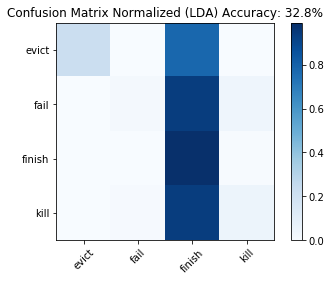

In [11]:
################ QDA ##################
# Train a QDA model on original features
qda = discriminant_analysis.QuadraticDiscriminantAnalysis().fit(X_train_scaled, y_train)

# Compute the predicted labels on test data
y_qda = qda.predict(X_test_scaled)

print("Acuracy of QDA : %.1f%%" % (metrics.accuracy_score(y_test,y_qda)*100))

compute_and_plot_cm(y_test, y_qda, data_class_labels, title="LDA")

Acuracy of QDA + PCA: 46.6%
[[0.91100703 0.03395785 0.00117096 0.05386417]
 [0.2804878  0.08902439 0.53536585 0.09512195]
 [0.27132701 0.05331754 0.62677725 0.0485782 ]
 [0.2915601  0.0601023  0.44757033 0.20076726]]


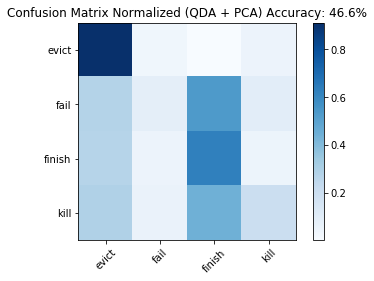

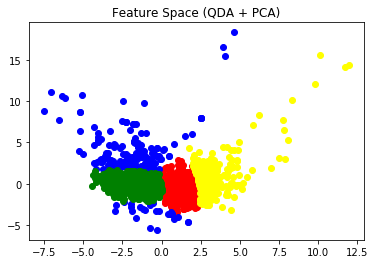

In [12]:
# Train a QDA model on pca extracted features
qda_pca = discriminant_analysis.QuadraticDiscriminantAnalysis().fit(X_train_scaled_pca, y_train)

# Compute the predicted labels on test data
y_qda_pca = qda_pca.predict(X_test_scaled_pca)

print("Acuracy of QDA + PCA: %.1f%%" % (metrics.accuracy_score(y_test,y_qda_pca)*100))

compute_and_plot_cm(y_test, y_qda_pca, data_class_labels, title="QDA + PCA")

plot_2d(X_test_scaled_pca, y_qda_pca, data_class_labels, title="QDA + PCA")

In [13]:
################ Polynomial expanded features ##################
# Train a polynomial expansion on original features
poly2 = preprocessing.PolynomialFeatures(degree=2).fit(X_train_scaled_pca)

# ... and apply it to the features
X_train_scaled_poly2 = poly2.transform(X_train_scaled_pca)
X_test_scaled_poly2 = poly2.transform(X_test_scaled_pca)

Acuracy of ELDA: 45.7%
[[0.87822014 0.         0.         0.12177986]
 [0.31463415 0.03536585 0.53414634 0.11585366]
 [0.28436019 0.03317536 0.62322275 0.05924171]
 [0.27493606 0.04987212 0.41560102 0.25959079]]


C:\WinPython\python-3.7.0b3.amd64\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


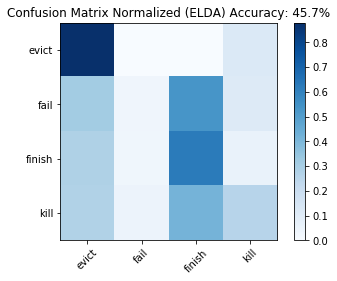

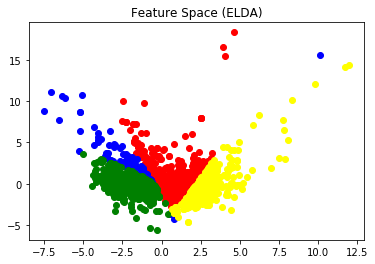

In [14]:
################  LDA on expanded ##################
# Train an LDA model on the original expanded features
lda_poly2 = discriminant_analysis.LinearDiscriminantAnalysis().fit(X_train_scaled_poly2, y_train)

# Compute the predicted labels on test data
y_lda_poly2= lda_poly2.predict(X_test_scaled_poly2)

print("Acuracy of ELDA: %.1f%%" % (metrics.accuracy_score(y_test,y_lda_poly2)*100))

compute_and_plot_cm(y_test, y_lda_poly2, data_class_labels, title="ELDA")

plot_2d(X_test_scaled_pca, y_lda_poly2, data_class_labels, title="ELDA")

Acuracy of SVM : 78.6%
[[1.         0.         0.         0.        ]
 [0.01585366 0.62560976 0.20121951 0.15731707]
 [0.00947867 0.18720379 0.68720379 0.11611374]
 [0.00511509 0.11508951 0.0511509  0.8286445 ]]
Acuracy of SVM +PCA: 56.2%
[[0.95784543 0.         0.00117096 0.04098361]
 [0.23414634 0.19146341 0.27560976 0.29878049]
 [0.22156398 0.07701422 0.41943128 0.28199052]
 [0.1202046  0.09335038 0.11253197 0.67391304]]


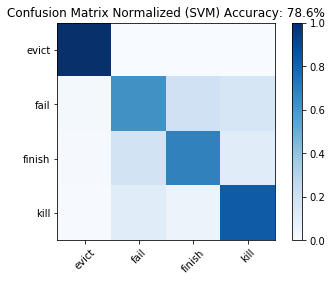

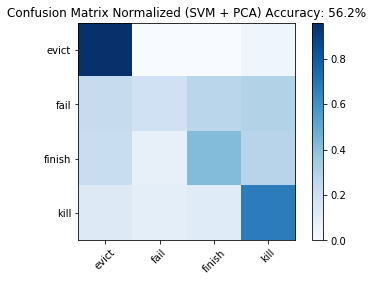

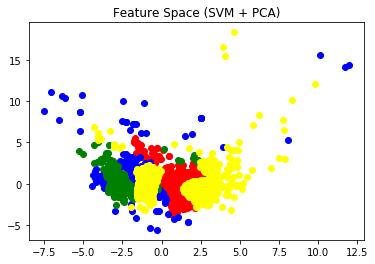

In [15]:
################ SVM ##################
# Train a SVM model on the original features
sv = svm.SVC().fit(X_train_scaled, y_train)

# Compute the predicted labels on test data
y_sv = sv.predict(X_test_scaled)
print("Acuracy of SVM : %.1f%%" % (metrics.accuracy_score(y_test,y_sv)*100))

# Show confusion matrix
compute_and_plot_cm(y_test, y_sv, data_class_labels, title="SVM")


# Train a SVM model on PCA extracted features
sv_pca = svm.SVC().fit(X_train_scaled_pca, y_train)

# Compute the predicted labels on test data
y_sv_pca = sv_pca.predict(X_test_scaled_pca)
print("Acuracy of SVM +PCA: %.1f%%" % (metrics.accuracy_score(y_test,y_sv_pca)*100))

# Show confusion matrix
compute_and_plot_cm(y_test, y_sv_pca, data_class_labels, title="SVM + PCA")

# Show data in 2D
plot_2d(X_test_scaled_pca, y_sv_pca, data_class_labels, title="SVM + PCA")\



Acuracy of DecisionTree: 82.9%
[[0.970726   0.029274   0.         0.        ]
 [0.01829268 0.73414634 0.14512195 0.10243902]
 [0.00947867 0.18483412 0.757109   0.0485782 ]
 [0.00383632 0.09462916 0.0511509  0.85038363]]
Acuracy of DecisionTree +PCA: 56.4%
[[0.93559719 0.01053864 0.00351288 0.05035129]
 [0.20365854 0.24146341 0.3        0.25487805]
 [0.21090047 0.11729858 0.41350711 0.25829384]
 [0.09462916 0.1342711  0.11381074 0.657289  ]]


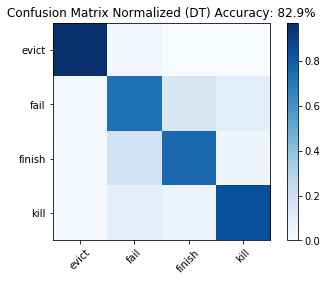

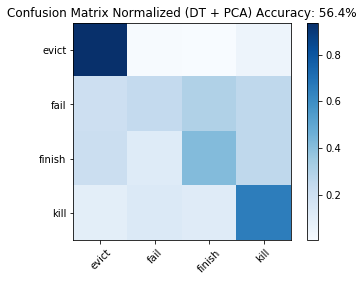

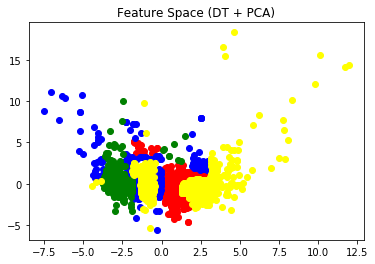

In [16]:
################ DecisionTree ##################
# Train a DT model on the original features
dt = tree.DecisionTreeClassifier(max_depth=5).fit(X_train_scaled, y_train)

# Compute the predicted labels on test data
y_dt = dt.predict(X_test_scaled)
print("Acuracy of DecisionTree: %.1f%%" % (metrics.accuracy_score(y_test,y_dt)*100))

# Show confusion matrix
compute_and_plot_cm(y_test, y_dt, data_class_labels, title="DT")

# Train a DT model on PCA extracted features
dt_pca = tree.DecisionTreeClassifier(max_depth=5).fit(X_train_scaled_pca, y_train)


# Compute the predicted labels on test data
y_dt_pca = dt_pca.predict(X_test_scaled_pca)

print("Acuracy of DecisionTree +PCA: %.1f%%" % (metrics.accuracy_score(y_test,y_dt_pca)*100))

# Show confusion matrix
compute_and_plot_cm(y_test, y_dt_pca, data_class_labels, title="DT + PCA")

# Show data in 2D
plot_2d(X_test_scaled_pca, y_dt_pca, data_class_labels, title="DT + PCA")




Acuracy of Random Forest: 88.0%
[[1.         0.         0.         0.        ]
 [0.00487805 0.82073171 0.10365854 0.07073171]
 [0.         0.12203791 0.82701422 0.05094787]
 [0.         0.09462916 0.03836317 0.86700767]]
Acuracy of Random Forest+PCA: 58.8%
[[0.89578454 0.03864169 0.03747073 0.02810304]
 [0.07439024 0.4804878  0.2304878  0.21463415]
 [0.11374408 0.26777251 0.45023697 0.16824645]
 [0.06393862 0.21355499 0.21099744 0.51150895]]


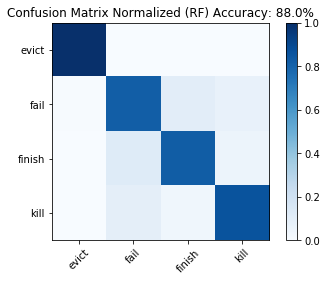

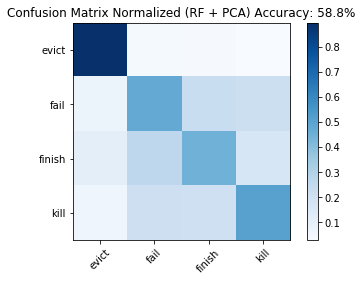

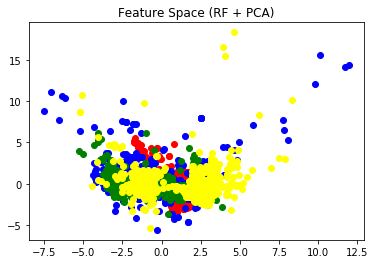

In [17]:
################ RandomForest ##################
# Train a RF model on the original features
rf = ensemble.RandomForestClassifier().fit(X_train_scaled, y_train)

# Compute the predicted labels on test data
y_rf = rf.predict(X_test_scaled)
print("Acuracy of Random Forest: %.1f%%" % (metrics.accuracy_score(y_test,y_rf)*100))

# Show confusion matrix
compute_and_plot_cm(y_test, y_rf, data_class_labels, title="RF")

# Train a Logit model on PDA extracted features
rf_pca = ensemble.RandomForestClassifier().fit(X_train_scaled_pca, y_train)

# Compute the predicted labels on test data
y_rf_pca = rf_pca.predict(X_test_scaled_pca)
print("Acuracy of Random Forest+PCA: %.1f%%" % (metrics.accuracy_score(y_test,y_rf_pca)*100))

# Show confusion matrix
compute_and_plot_cm(y_test, y_rf_pca, data_class_labels, title="RF + PCA")

# Show data in 2D
plot_2d(X_test_scaled_pca, y_rf_pca, data_class_labels, title="RF + PCA")